<a href="https://colab.research.google.com/github/Debora101/PCA-Milk/blob/main/PCA_milk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

A Espectroscopia de Infravermelho Próximo, também conhecida como NIR ou NIRS, é uma técnica que permite analisar principalmente amostras orgânicas (e algumas inorgânicas) através da emissão de radiação eletromagnética no infravermelho próximo de 780nm a 2500nm.


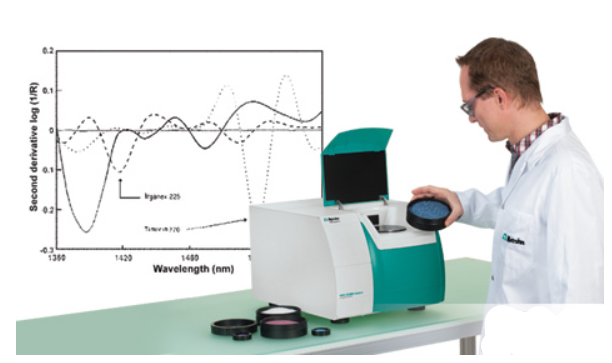








**Objetivo do trabalho:** Apresentar um tutorial sobre como executar uma classificação de espectros NIR usando a Análise de Componentes Principais (PCA).

A Análise de Componentes Principais (PCA) é frequentemente empregada na análise de dados de Infravermelho Próximo (NIR) por motivos válidos. Os espectros de NIR são normalmente coletados em uma ampla gama de comprimentos de onda. Por exemplo, os dados mencionados neste texto foram obtidos em 601 diferentes comprimentos de onda, espaçados cada um por 2 nanômetros.

Em geral, ter 601 pontos de dados para cada espectro é considerado excessivamente redundante. Os espectros NIR são caracterizados por sua escassez de informações, geralmente não apresentando características distintas, como picos de absorção, que são comuns em espectroscopias como Raman ou MIR. Essa falta de definição implica que muitos dos atributos dos espectros NIR em diferentes comprimentos de onda são altamente correlacionadas.

É aí que a PCA entra em cena. A PCA é muito eficiente na redução da dimensionalidade de dados multidimensionais que apresentam um alto nível de correlação. A PCA elimina os componentes correlacionados dos dados ao projetar o conjunto de dados multidimensionais (de 601 dimensões, neste caso) para um espaço de dimensionalidade muito mais baixa, geralmente para apenas algumas, ou até mesmo somente duas dimensões.
Essas operações básicas nos dados geralmente são feitas usando o software quimiométrico, e há muitas opções excelentes no mercado.



- 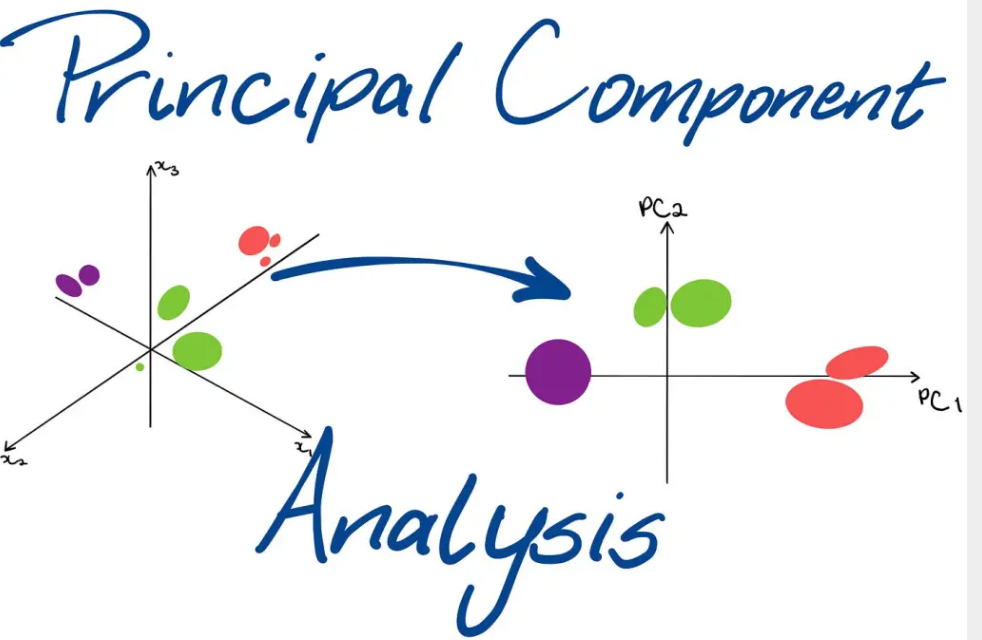





# Preparação dos dados


Utilizaremos espectros NIR de amostras de leite com concentrações variadas de lactose. Para preparar as amostras, misturamos leite comum e leite sem lactose em diferentes proporções. O objetivo é verificar se a aplicação da PCA aos espectros pode ajudar a diferenciar as diversas concentrações de lactose.





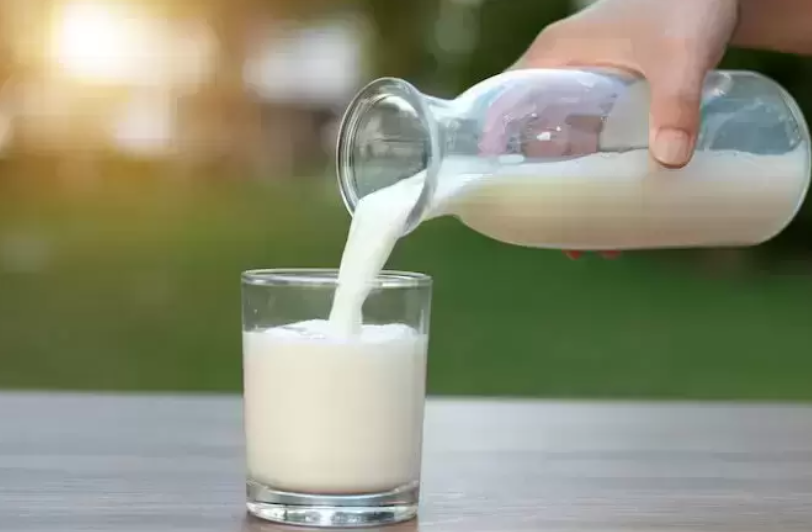


Os dados estão armazenados em um arquivo CSV que contém 450 digitalizações. Cada digitalização possui um rótulo numérico (de 1 a 9), que identifica a amostra analisada. Cada amostra foi submetida a 50 digitalizações, e a distinção entre as amostras reside na proporção relativa de leite comum e leite sem lactose."


O objetivo do projeto é detectar a presença de lactose em amostras de leite, diferenciando leite com lactose (leite comum) do leite sem lactose.
Foram preparadas amostras com diferentes proporções de leite comum e leite sem lactose. As proporções variam em intervalos de 1/8, começando com uma amostra que tem 1/8 de leite comum e 7/8 de leite sem lactose, até uma amostra com 100% de leite comum.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA as pca
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cluster import KMeans

In [ ]:
url = pd.read_csv("/content/milk.csv")
url.head()


,Unnamed: 0,labels,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,601,602
0,1/02/2018,1,2.397526,2.394200,2.388952,2.381282,2.371906,2.360940,2.349092,2.336749,...,0.109473,0.111015,0.113123,0.115745,0.118939,0.122773,0.127250,0.132313,0.137997,0.144151
1,1/02/2018.1,1,2.399526,2.396723,2.391678,2.383280,2.372825,2.361160,2.348541,2.336346,...,0.108937,0.110649,0.112845,0.115586,0.118847,0.122642,0.127013,0.131837,0.137191,0.143028
2,1/02/2018.2,1,2.396475,2.393600,2.388446,2.380985,2.371319,2.359930,2.348114,2.336348,...,0.108358,0.110062,0.112391,0.115298,0.118736,0.122774,0.127359,0.132500,0.138217,0.144524
3,1/02/2018.3,1,2.406880,2.404243,2.399203,2.391142,2.380536,2.368569,2.356339,2.344046,...,0.110105,0.111836,0.114057,0.116744,0.119888,0.123524,0.127728,0.132561,0.138030,0.144085
4,1/02/2018.4,1,2.409883,2.407017,2.401310,2.392669,2.381365,2.368603,2.355518,2.342792,...,0.110129,0.111469,0.113277,0.115589,0.118503,0.122092,0.126346,0.131227,0.136840,0.143176


In [ ]:
# Import data from csv on github
url = '/content/milk.csv'
data = pd.read_csv(url)

# The first column of the Data Frame contains the labels
lab = data.values[:,1].astype('uint8')

# Read the features (scans) and transform data from reflectance to absorbance
feat = np.log(1.0/(data.values[:,2:]).astype('float32'))



Ao analisar dados de espectroscopia NIR, tomar a primeira derivada dos dados é essencial para corrigir diferenças na linha de base das varreduras e destacar as principais variações entre elas. Para contornar a instabilidade dos derivados numéricos, utilizamos o filtro de suavização disponível em scipy.signal, conhecido como savgol_filter, para suavizar os dados após a derivação."



In [ ]:
# Calculate first derivative applying a Savitzky-Golay filter
dfeat = savgol_filter(feat, 25, polyorder = 5, deriv=1)

# Selecionando o número certo de componentes principais

Conforme discutido anteriormente, empregaremos a Análise de Componentes Principais (PCA) para diminuir a dimensionalidade dos nossos dados. Isso significa reduzir a quantidade de variáveis de 601 (comprimentos de onda) para um número substancialmente menor.

Aqui surge uma questão crucial: q**uantos atributos realmente precisamos**? A abordagem para responder a isso pode parecer um pouco atípica em comparação com procedimentos comuns em algumas análises estatísticas.

Cada componente principal que identificarmos vai capturar uma porção da variação nos dados. O primeiro componente principal é o que explica a maior parte dessa variação, o segundo um pouco menos, e assim sucessivamente. Para detalhar um pouco mais, é possível discutir a variação explicada por cada componente principal individualmente. A soma das variações explicadas por todos os componentes principais é conhecida como a variação total.







A orientação comum é selecionar os primeiros n componentes principais que abrangem a maior parte da variação, frequentemente um limiar de 95%, 90%, ou até 85%, a depender do contexto específico. Contudo, esta estratégia pode não ser tão eficaz para dados de espectroscopia NIR, particularmente quando tratamos de dados derivados.

A seguir, um gráfico que ilustra tanto a variação explicada quanto a variação acumulada pelos 10 primeiros componentes principais extraídos de nossos dados.

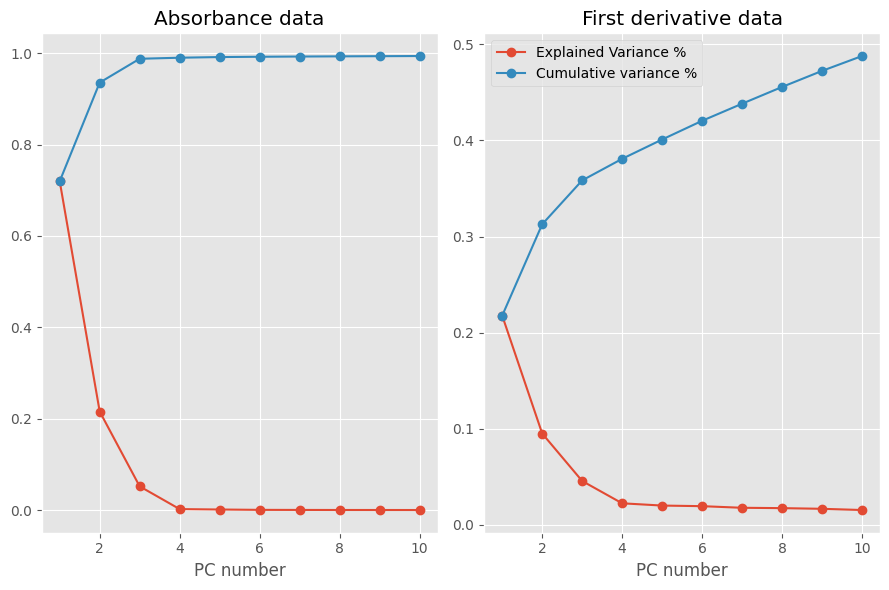

In [ ]:

# Initialise
nc = 10
pca1 = pca(n_components=nc)
pca2 = pca(n_components=nc)

# Scale the features to have zero mean and standard devisation of 1
# This is important when correlating data with very different variances
nfeat1 = StandardScaler().fit_transform(feat)
nfeat2 = StandardScaler().fit_transform(dfeat)

# Fit the spectral data and extract the explained variance ratio
X1 = pca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_

# Fit the first data and extract the explained variance ratio
X2 = pca2.fit(nfeat2)
expl_var_2 = X2.explained_variance_ratio_

# Plot data
pc_array = np.linspace(1,nc,nc)
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)

    ax1.plot(pc_array, expl_var_1,'-o', label="Explained Variance %")
    ax1.plot(pc_array, np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('Absorbance data')

    ax2.plot(pc_array, expl_var_2,'-o', label="Explained Variance %")
    ax2.plot(pc_array, np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title('First derivative data')

    plt.legend()
    plt.show()

No gráfico à esquerda, estão representados os resultados do PCA aplicado aos dados originais de absorvância, enquanto no lado direito, vemos o PCA realizado nos primeiros dados derivados.

Na análise dos dados originais, observamos que três componentes principais abrangem a maior parte da variação, atingindo 98,8% para ser exato. Os componentes seguintes contribuem de forma mínima. No entanto, a situação muda drasticamente quando aplicamos o PCA aos primeiros dados derivativos. Neste caso, cada componente principal adiciona significativamente à variação explicada, sugerindo que vários outros componentes seriam necessários para cobrir a maior parte da variação.

Então, o que está causando essa diferença?

A resposta parece estar no ruído contido nos dados. O ruído é exacerbado pela operação de derivação numérica, razão pela qual um filtro de suavização é necessário. Porém, este filtro não elimina completamente o ruído. O ruído residual, que não é correlacionado de uma varredura para outra, não pode ser eficientemente representado por poucos componentes principais.

A boa notícia é que as variações mais significativas nos dados ainda são capturadas por um número reduzido de componentes principais (3-4). Os componentes de ordem superior, identificados na decomposição dos primeiros dados derivativos, estão majoritariamente relacionados ao ruído. De fato, observa-se que após os quatro primeiros componentes principais nos dados derivativos, a variação explicada torna-se mínima, indicando a predominância de ruído aleatório.

Portanto, uma estratégia eficaz **é determinar o número de componentes principais a serem utilizados com base na variação acumulada observada nos dados espectrais decompostos**, mesmo que frequentemente recorramos aos primeiros dados derivativos para uma classificação mais acurada."

# PCA com 4 componentes

Certo, agora chegamos à etapa mais simples. Uma vez que determinamos a quantidade de componentes principais a serem utilizados – por exemplo, escolhendo 4 componentes –, tudo o que resta é configurar a nova transformação e aplicá-la aos primeiros dados derivativos."







In [ ]:
pca2 = pca(n_components=4)

# Transform on the scaled features
Xt2 = pca2.fit_transform(nfeat2)

Apresentando o gráfico de dispersão dos dois primeiros componentes principais."







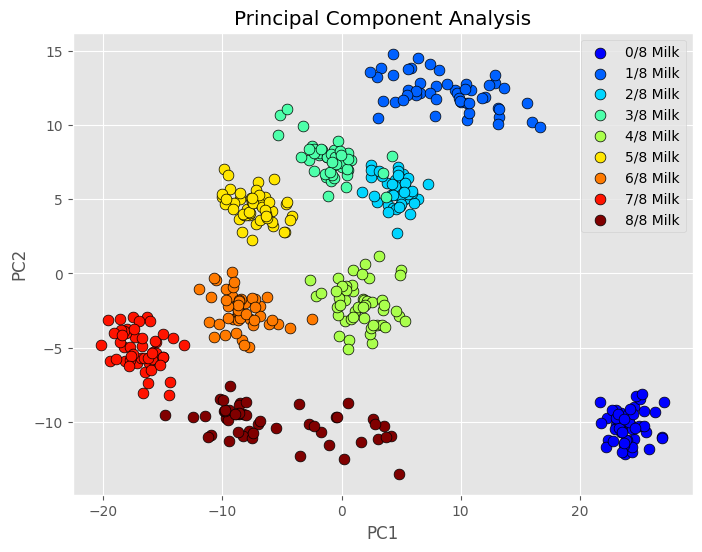

In [ ]:
# Define the labels for the plot legend
labplot = ["0/8 Milk","1/8 Milk","2/8 Milk", "3/8 Milk", \
"4/8 Milk", "5/8 Milk","6/8 Milk","7/8 Milk", "8/8 Milk"]

# Scatter plot
unique = list(set(lab))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
with plt.style.context(('ggplot')):
    plt.figure(figsize=(8,6))
    for i, u in enumerate(unique):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt2[j,0] for j in range(len(Xt2[:,0])) if lab[j] == u]
        yi = [Xt2[j,1] for j in range(len(Xt2[:,1])) if lab[j] == u]
        plt.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(labplot,loc='upper right')
    plt.title('Principal Component Analysis')
    plt.show()

Interpretação dos Rótulos em "labplot":
- Cada rótulo em labplot — "0/8 Milk", "1/8 Milk", até "8/8 Milk" — representa uma dessas amostras com uma proporção específica de leite comum e leite sem lactose.
- Por exemplo, "1/8 Milk" se refere à amostra que tem 1/8 de leite comum e 7/8 de leite sem lactose, enquanto "8/8 Milk" seria 100% leite comum.